# Twitter Streaming with pySpark

In [1]:
#we use the findspark library to locate spark on our local machine

import findspark
findspark.init('Spark Directory')

In [3]:
# import necessary packages

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [4]:
# we create an instance of SparkContext. we can run this only once since it initiates the entry point and runs 
#the operations inside the executors on worker nodes. if you face any issue, just restart the kernel and run it again.
sc = SparkContext()

In [5]:
# we initiate the StreamingContext with 10 second batch interval. next we initiate our sqlcontext
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [6]:
# initiate streaming text from a TCP (socket) source:
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [7]:
# lines of tweets with socket_stream window of size 60, or 60 seconds windows of time
lines = socket_stream.window(60) 

In [8]:
# just a tuple to assign names

from collections import namedtuple

fields = ("hashtag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [9]:
# here we apply different operations on the tweets and save them to a temporary sql table

( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) 
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a dataframe
  .limit(10).registerTempTable("tweets") ) ) # Registers only top 10 hashtags to a table.

__________
### At this point, we must run "receive_tweets.py" file
__________

In [11]:
# import libraries to visualize the results

import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline 

In [12]:
# start streaming and wait couple of minutes to get enought tweets
ssc.start()

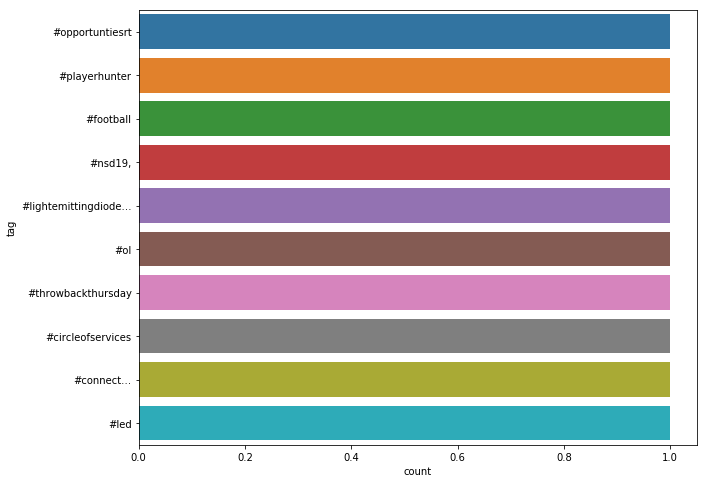

In [13]:

count = 0
while count < 5:
    
    time.sleep(5)
    top_10_tags = sqlContext.sql( 'Select hashtag, count from tweets' )
    top_10_df = top_10_tags.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="hashtag", data=top_10_df)
    plt.show()
    count = count + 1
    print(conut)

In [14]:
ssc.stop()